In [38]:
import os
import math
import numpy as np
import tensorflow as tf
import keras
import tensorflow_addons as tfa
import random 
import cv2

import pandas as pd
from keras import layers
from tensorflow.keras import backend as K
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [19]:
def build_augmentation(is_train=True):
    if is_train:  # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),  # 50%의 확률로 좌우대칭
            RandomSizedCrop(  # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(  # 입력 이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    
    return Compose([  # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

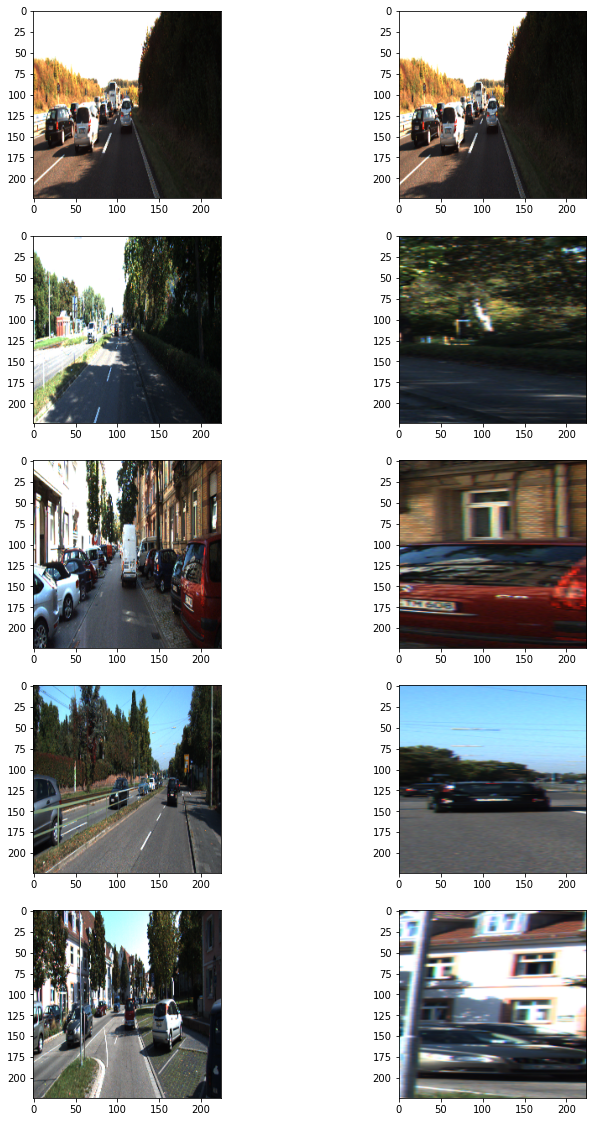

In [20]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

## 이진 분류 데이터 전처리

In [43]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)


## 다중 분류 데이터 전처리

In [21]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        batch_data = self.data[
            index * self.batch_size:
            (index + 1) * self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size, 17])  # num_classes를 직접 넣어도 됩니다.
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)

            # 레이블의 개수에 따라 클래스 수를 설정 (예: 17개 클래스)
            num_classes = 17  
            _output_one_hot = np.zeros((*_output.shape, num_classes), dtype=np.uint8)  # 원-핫 인코딩을 위한 제로 배열
            
            # 각 픽셀에 대해 레이블을 설정
            for class_index in range(num_classes):
                _output_one_hot[..., class_index] = (_output == class_index).astype(np.uint8)

            data = {
                "image": _input,
                "mask": _output_one_hot,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
        
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
   




In [22]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [101]:
test_generator.__getitem__(0)[1].shape

(16, 224, 224, 17)

In [113]:
np.max(model.predict(test_generator.__getitem__(0)[0]))

0.28040418

In [103]:
 tf.keras.metrics.MeanIoU(num_classes=num_classes, name='iou')

In [104]:
# iou = true_positives / (sum_row + sum_col - true_positives))
#result = (1 / (2 + 2 - 1) + 1 / (2 + 2 - 1)) / 2 = 0.33
m = tf.keras.metrics.MeanIoU(num_classes=17)
m.update_state(test_generator.__getitem__(0)[1],model.predict(test_generator.__getitem__(0)[0]))
m.result().numpy()


0.48867112

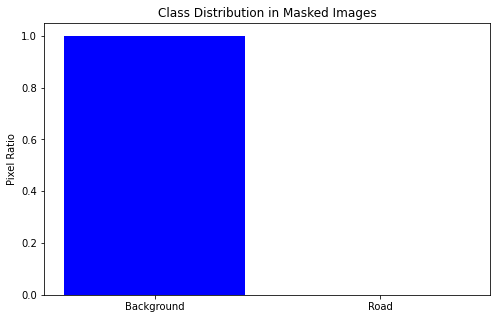

In [14]:
# 클래스 정의
BACKGROUND_CLASS = 0  # 배경
ROAD_CLASS = 1        # 도로
NUM_CLASSES = 2       # 두 클래스 (배경, 도로)

def visualize_mask_class_distribution(generator):
    # 각 클래스의 픽셀 수를 카운트합니다.
    class_counts = np.zeros(NUM_CLASSES)
    
    for input_img_path, label_img_path in generator.data:
        # 마스크 이미지를 로드합니다.
        mask_img = imread(label_img_path)
        
        # 각 픽셀에 대해 클래스를 카운트합니다.
        for cls in range(NUM_CLASSES):
            class_counts[cls] += np.sum(mask_img == cls)

    # 클래스 비율을 계산합니다.
    total_pixels = np.sum(class_counts)
    class_ratios = class_counts / total_pixels

    # 클래스 분포를 시각화합니다.
    plt.figure(figsize=(8, 5))
    plt.bar(range(NUM_CLASSES), class_ratios, color=['blue', 'orange'])
    plt.xticks(range(NUM_CLASSES), ['Background', 'Road'])
    plt.ylabel('Pixel Ratio')
    plt.title('Class Distribution in Masked Images')
    plt.show()

# 데이터 생성기 인스턴스 생성
train_generator = KittiGenerator(dir_path, augmentation=augmentation)

# 클래스 분포 시각화
visualize_mask_class_distribution(train_generator)

완벽한 class의 불균형을 확인할 수 있었다. 

## U-net model

In [23]:
def build_model(input_shape=(224, 224, 3), num_classes = 17):
    inputs = layers.Input(shape=input_shape)

    # 인코더
    # 첫 번째 인코딩 블록
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # 두 번째 인코딩 블록
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # 세 번째 인코딩 블록
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # 네 번째 인코딩 블록
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # 바닥층
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # 디코더
    # 첫 번째 디코딩 블록
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    # 두 번째 디코딩 블록
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    # 세 번째 디코딩 블록
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    # 네 번째 디코딩 블록
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # 출력 레이어
    outputs = layers.Conv2D(17, (1, 1), activation='softmax')(c9)

    # 모델 생성
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [122]:
#model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'


csv_logger = CSVLogger('./u-net_training_log.csv', append=True)

model_checkpoint = ModelCheckpoint(
    filepath='./u-net_epoch_{epoch:02d}.h5', 
    save_weights_only=True,  # 모델 가중치만 저장
    save_best_only=False,    # 매 에포크마다 저장
    verbose=1
)


callback_list = [csv_logger, model_checkpoint]

model = build_model(num_classes = 17)

# 손실 함수 및 메트릭 설정
num_classes = 17
focal_loss = tfa.losses.SigmoidFocalCrossEntropy(gamma=2.0, alpha=0.25)



## custom iou 에서 one hot된 값을 mean iou metrix에 넣기 


model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
              loss=focal_loss,  
              metrics=[
                    tf.keras.metrics.MeanIoU(num_classes = num_classes,name = 'iou')
              ])


model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
     callbacks = callback_list
)

Epoch 1/200
11/11 [==============================] - 17s 1s/step - loss: 0.2353 - iou: 0.4886 - val_loss: 0.2088 - val_iou: 0.4885

Epoch 00001: saving model to ./u-net_epoch_01.h5
Epoch 2/200
11/11 [==============================] - 14s 1s/step - loss: 0.1829 - iou: 0.4886 - val_loss: 0.1837 - val_iou: 0.4885

Epoch 00002: saving model to ./u-net_epoch_02.h5
Epoch 3/200
11/11 [==============================] - 14s 1s/step - loss: 0.1598 - iou: 0.4886 - val_loss: 0.1696 - val_iou: 0.4885

Epoch 00003: saving model to ./u-net_epoch_03.h5
Epoch 4/200
11/11 [==============================] - 14s 1s/step - loss: 0.1420 - iou: 0.4887 - val_loss: 0.1718 - val_iou: 0.4885

Epoch 00004: saving model to ./u-net_epoch_04.h5
Epoch 5/200
11/11 [==============================] - 14s 1s/step - loss: 0.1480 - iou: 0.4884 - val_loss: 0.1733 - val_iou: 0.4885

Epoch 00005: saving model to ./u-net_epoch_05.h5
Epoch 6/200
11/11 [==============================] - 14s 1s/step - loss: 0.1399 - iou: 0.4888 -

## loss 값 시각화

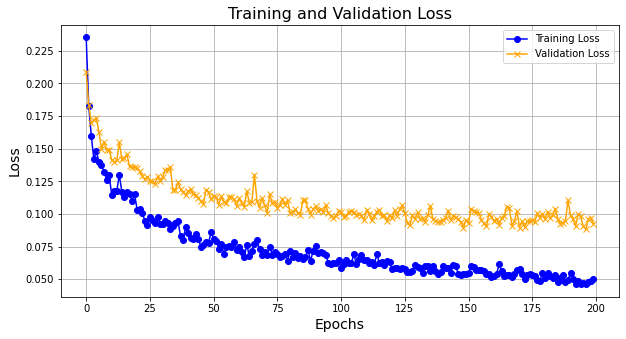

In [53]:
# 데이터 로드
data = pd.read_csv('./u-net_training_log.csv')

# 손실과 검증 손실 값 추출
loss = data['loss']  # 훈련 손실
val_loss = data['val_loss']  # 검증 손실
epochs = data['epoch']  # 에포크 번호 (이 열이 없다면, range(len(loss))를 사용 가능)

# 그래프 설정
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='x')

# 축 레이블 설정
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.grid()

# 그래프 보여주기
plt.show()

loss로만 봐서는 더 감소할거 같아서 최적화 지점을 찾기가 어려웠다.

그래서 mean iou metrix를 추가했지만 계속 같은 iou 값이 나오는 문제가 있어서 모델의 최적화 지점을 찾는데 mean iou 값을 활용하지 못했다.

In [24]:
model = build_model(num_classes = 17)
model.load_weights('./u-net_epoch_200.h5')

In [31]:
output.shape

(224, 224)

## 다중 분류 결과 확인

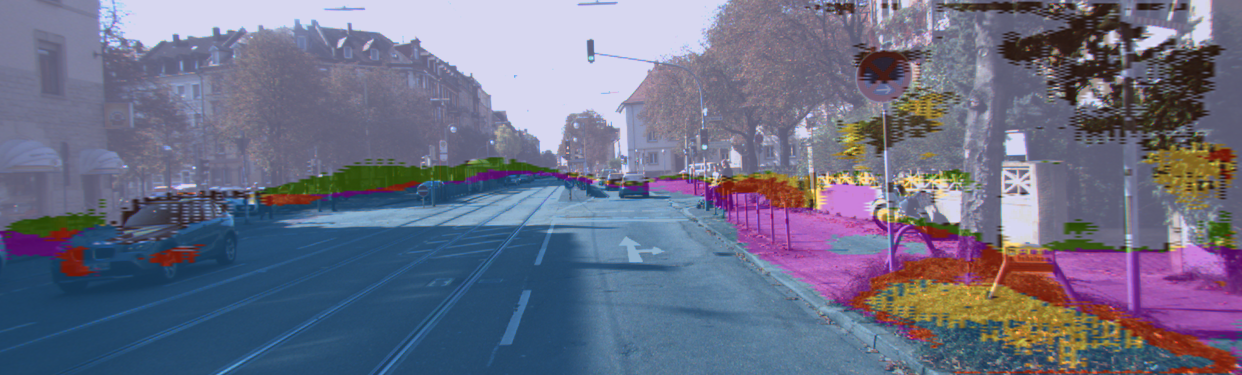

OSError: [Errno 30] Read-only file system: '/aiffel/aiffel/semantic_segmentation/data/training/result_001.png'

In [52]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    
    # 각 클래스에 대해 RGB 색상 맵을 정의합니다 (예: 17개의 클래스를 색상별로 구분)
    class_colors = np.random.randint(0, 255, size=(17, 3), dtype=np.uint8)
    
    # 17개의 클래스 중에서 가장 높은 확률을 갖는 클래스 인덱스를 선택합니다.
    class_map = np.argmax(output[0].numpy(), axis=-1)
    
    # 클래스 인덱스를 RGB 이미지로 변환
    seg_img = class_colors[class_map]
    
    # 결과 이미지 생성 및 원본과 합성
    seg_img = Image.fromarray(seg_img)
    background = Image.fromarray(origin_img).convert('RGBA')
    seg_img = seg_img.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    
    # 50% 투명도로 원본과 블렌딩
    blended = Image.blend(background, seg_img, alpha=0.5)
    blended.show()
    
    # 결과 저장
    blended.save(output_path)
    return blended

# 테스트용 파일 설정
i= 1
get_output(
        model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'/result_{str(i).zfill(3)}.png'
)

## 고찰

도로의 segmentation은 주변에 차같은 다른 object가 있어도 잘 수행되었지만 옆의 인도도 도로와 rgb 같이 비슷한 벽의 일부도 같이 segmentation이 되는 문제점이 생겼다. 

u-net에서 오른쪽의 edge부분을 잘 찾지 못하거나 rgb 값이 인도와 비슷하여 edge로 인식하지 못하는 상황이 발생한거 같다. 
만약 u-net++도 같이 상황에 있으면 brithness, filp data augumentation을 고려해봐야 겠다. 

다중 분류로 바꾸고 focal loss를 사용해봐도 여전히 edge부분은 잘 segmentation 하지 못하고 있다. 

경계면에 weight map를 써보면 달라질것 같은데 어떻게 weight map를 추가해야 될지는 잘 모르겠다.


In [28]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image": origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"] / 255, axis=0))
    output = (output[0].numpy() > 0.5).astype(np.uint8).squeeze(-1) * 255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output


In [29]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [34]:
def calculate_iou_score(target, prediction):
    # Flatten the arrays
    target_flat = target.flatten()
    prediction_flat = prediction.flatten()

    # Calculate intersection
    intersection = np.sum((target_flat == 1) & (prediction_flat == 1))

    # Calculate union
    union = np.sum((target_flat == 1) | (prediction_flat == 1))

    # Calculate IoU score
    iou_score = float(intersection) / union if union != 0 else 0.0
    
    print('IoU : %f' % iou_score)
    return iou_score

In [35]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [36]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

ValueError: cannot select an axis to squeeze out which has size not equal to one

## U-NET++

In [54]:
def conv_block(x, filters, kernel_size=(3, 3), padding="same", activation="relu"):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


In [55]:
def dense_block(x, filters, num_layers):
    for _ in range(num_layers):
        x = conv_block(x, filters)
    return x


In [62]:
def UNetPlusPlus(input_shape=(224, 224, 3), num_classes=17):
    inputs = layers.Input(shape=input_shape)

    # Encoder path with dense blocks and skip connections
    e1 = dense_block(inputs, 64, 2)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = dense_block(p1, 128, 2)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = dense_block(p2, 256, 2)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    e4 = dense_block(p3, 512, 2)
    p4 = layers.MaxPooling2D((2, 2))(e4)

    # Bottleneck
    bottleneck = dense_block(p4, 1024, 2)

    # Decoder path with nested skip connections
    d4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bottleneck)
    d4 = layers.concatenate([d4, e4])
    d4 = dense_block(d4, 512, 2)

    d3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(d4)
    d3 = layers.concatenate([d3, e3, layers.Conv2D(256, (3, 3), padding="same")(e4)])
    d3 = dense_block(d3, 256, 2)

    d2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(d3)
    d2 = layers.concatenate([d2, e2, layers.Conv2D(128, (3, 3), padding="same")(d3)])
    d2 = dense_block(d2, 128, 2)

    d1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(d2)
    d1 = layers.concatenate([d1, e1, layers.Conv2D(64, (3, 3), padding="same")(d2)])
    d1 = dense_block(d1, 64, 2)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(d1)

    model = Model(inputs, outputs, name="UNetPlusPlus")
    return model

In [65]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef(y_true, y_pred)


In [ ]:
#최적화 지점을 찾는 loss 값에서는 bce_dice loss를 사용하고 metrix에 focal loss를 추가하여 평가는 focal loss로 진행
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus_plus.h5'


model = build_model()

focal_loss = tfa.losses.SigmoidFocalCrossEntropy(gamma=2.0, alpha=0.25)
model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss , metrics = [focal_loss])


csv_logger = CSVLogger('./u-net_training_log.csv', append=True)

model_checkpoint = ModelCheckpoint(
    filepath='./u-net++_epoch_{epoch:02d}.h5', 
    save_weights_only=True,  # 모델 가중치만 저장
    save_best_only=False,    # 매 에포크마다 저장
    verbose=1
)


callback_list = [csv_logger, model_checkpoint]

model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
     callbacks = callback_list
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/200
11/11 [==============================] - 17s 1s/step - loss: 0.3735 - sigmoid_focal_crossentropy: 0.2462 - val_loss: 0.3680 - val_sigmoid_focal_crossentropy: 0.2566

Epoch 00001: saving model to ./u-net++_epoch_01.h5
Epoch 2/200
11/11 [==============================] - 14s 1s/step - loss: 0.3407 - sigmoid_focal_crossentropy: 0.2892 - val_loss: 0.2929 - val_sigmoid_focal_crossentropy: 0.4725

Epoch 00002: saving model to ./u-net++_epoch_02.h5
Epoch 3/200
11/11 [==============================] - 13s 1s/step - loss: 0.2410 - sigmoid_focal_crossentropy: 0.5895 - val_loss: 0.1771 - val_sigmoid_focal_crossentropy: 0.5716

Epoch 00003: saving model to ./u-net++_epoch_03.h5
Epoch 4/200
11/11 [==============================] - 14s 1s/step - loss: 0.1332 - sigmoid_focal_crossentropy: 0.6377 - val_loss: 0.1309 - val_sigmoid_focal_crossentropy: 0.4459

Epoch 00004: saving model to ./u-net++_epoch_04.h5
Epoch 5/200
11/11 [==============================] - 14s 1s/step - loss: 0.1122 - si

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## U_net++ 고찰

u-net과 똑같이 오른쪽 부분의 인도를 도로로 인식하는 문제점을 발견할 수 있다.

1. class의 불균형이 생겨서 편향된 예측을 한것 같다. -> side worker  부분에서 잘못 예측 되어 이 fp 부분에 가중치를 두어 focal loss로 class의 불균형을 완화해주는 loss을 써봐야 겠다. 

2. 이러한 문제가 training 데이터가 오른쪽 부은 깨끗한 경우가 많아서 오른쪽 부분에 장애물이 많이 있는 패턴을 잘 segmentation 하지 못하는 문제점이 생겼을 것 같다 -> flip augumentation을 사용하여 다양한 패턴을 학습시켜 봐야 겠다. 

3. 딥러닝 네트워크는 저주파 부분을 잘 학습하지만 고주파 영역을 잘 학습하지 못하는 문제점이 있었다. 이러한 문제점으로 고주파 영역의 도로와 인도 사이의 edge부분을 잘 학습하지 못한거 같다. -> gaussian noise를 통해 고주파 영역과 저주파 여영 

## 회고


딥러닝 모델 자체가 저주파 영역은 잘학습하지만 고주파 영역은 잘 학습하지 못하는 문제점을 가지고 있다는 것을 확인하여 edge 부분의 segmentation을 잘 분리 못하는 문제점을 경계면에 weighted map를 사용하여 해결하려 했으나 어떠한 방식으로 weight map을 적용해야 될지 감이 안잡혀 사용하지 못한것이 아쉽다.

mean iou 값의 변경되지 않은 문제점을 찾아서 좋긴하지만 시간을 너무 오래 쓴거 같았다.